In [1]:
from GRLT_analysis.data_loader import data_loader
import pandas as pd
from functools import reduce
from GRLT_analysis.feature_selection import forward_subset_selection
from GRLT_analysis.feature_selection import lasso_feature_selection

In [2]:
datapaths = ["conditions_gastrointestinal.csv", "dog_profile.csv", "environment_conditions.csv", "environment_spend_time_location.csv", "exam_physical.csv", "poison_exposure.csv", "study_endpoints.csv"]

In [3]:
dfs = []
for index, datapath in enumerate(datapaths):
    print("Adding: ", datapath)
    full_path = "data/" + datapath
    temp = data_loader(file_path=full_path)
    temp.download_csv()
    temp.identify_type()
    temp.clean_junk()
    temp.select_year("all")
    if index == len(datapaths) - 1:
        temp.age_death_variable()
    dfs.append(temp.file)

Adding:  conditions_gastrointestinal.csv
For context, there are 16.0 entries in this dataset per unique dog for the timeframe you have selected
Adding:  dog_profile.csv
For context, there are 1.0 entries in this dataset per unique dog for the timeframe you have selected
year in study is not an included variable in this dataset, this dataset is not valid to use for this function
Adding:  environment_conditions.csv
For context, there are 12.709592641261498 entries in this dataset per unique dog for the timeframe you have selected
Adding:  environment_spend_time_location.csv
day_outdoor_garage
day_outdoor_kennel
day_outdoor_fenced
day_outdoor_chain_or_lead
day_outdoor_other_percentage
day_outdoor_total_percentage
For context, there are 5.483902759526938 entries in this dataset per unique dog for the timeframe you have selected
Adding:  exam_physical.csv
For context, there are 6.889618922470434 entries in this dataset per unique dog for the timeframe you have selected
Adding:  poison_expos

In [4]:
def merge_avoiding_duplicates(left, right):
    cols_to_drop = [col for col in right.columns if col in left.columns and col != 'subject_id__I']
    right = right.drop(columns=cols_to_drop)
    return pd.merge(left, right, on='subject_id__I', how='left')

merged_df = reduce(merge_avoiding_duplicates, dfs)
merged_df

,subject_id__I,year_in_study__Q_x,index,year_in_study__Q_y,relationship_category__C,to_date__C,any__C,acid_reflux__C,acute_colitis__C,bacterial_overgrowth__C,...,mucous_membrane_cyanotic__C,year_in_study__Q,PoisonControlLastYear__Q,PoisonControlMoreThanTwice__Q,tier_of_confidence__Q,status__C,is_cause_of_death__C,is_recurrence__C,is_adjudicated__C,lifespan_days__Q
0,grls007MPNZZ,3.5,0,0,DOG,0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
1,grls00NB23WW,3.5,16,0,DOG,0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,1.0,final,1.0,0.0,1.0,2070 days
2,grls01C2L8RR,3.5,32,0,DOG,0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,1.0,final,1.0,0.0,1.0,3011 days
3,grls01LNL888,3.5,48,0,DOG,0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
4,grls01RDAKNN,3.5,64,0,DOG,0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3201,grlsZW6L5W33,3.5,48624,0,DOG,0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT
3202,grlsZY1Z1OSS,3.5,48640,0,DOG,0,1.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,1.0,final,1.0,0.0,1.0,3103 days
3203,grlsZY5KYKXX,3.5,48656,0,DOG,0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,0.0,1.0,definitive,0.0,0.0,0.0,2617 days
3204,grlsZYI0K6LL,3.5,48672,0,DOG,0,0.0,0.0,0.0,0.0,...,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT


In [5]:
df_filtered = merged_df[merged_df['lifespan_days__Q'].notna()] # Only use entries with usable life-lengths
df_filtered = df_filtered.loc[:, df_filtered.nunique() > 1] # Remove any useless columns which snuck in

life_lengths = df_filtered['lifespan_days__Q'].dt.days.to_numpy()
life_lengths = life_lengths.astype(float)
# print(life_lengths)

df_filtered = df_filtered.select_dtypes(exclude=['object', 'string', 'datetime'])
data_array = df_filtered.values[:,1:-1]
data_array = data_array.astype(float)
# print(data_array)

In [ ]:
selected_features, theta, preds, mse, r2 = forward_subset_selection(
    data_array, life_lengths, val_ratio=0.2, epsilon=1e-100, max_features=15)

In [8]:
column_names = df_filtered.columns[selected_features].tolist()
column_names

['furniture_type_other__Q',
 'tier_of_confidence__Q',
 'any_treated_insects__C',
 'indoor_tile_flooring__Q',
 'use_aerosol__Q',
 'furniture_type_upholstered__Q',
 'indoor_furniture_flooring__Q',
 'vomiting__C',
 'diarrhea__C',
 'any_treated_weeds__C',
 'indoor_cement_flooring__Q',
 'indoor_other_flooring__Q',
 'smoke_exposure__Q',
 'pulse__C',
 'furniture_type_leather__Q']

In [9]:
for index, name in enumerate(column_names):
    print(index, "\tCategory: ", name, "\t\tCoeff: ", theta[index])

# Top explanatory variables:
# Tier of confidence -- confidence in fatal diagnosis (negative)
# Vomiting -- record of routine vomiting in gastrointestinal conditions (negative)
# Use aerosol -- home often uses aerosol (negative)
# Capillary Refill Not Evaluated -- did not evaluate blood flow in appointment (negative)
# Any Treated Insects -- home treated for insects (negative)
# Any Treated Weeds -- home treated for weeds (negative)


0 	Category:  furniture_type_other__Q 		Coeff:  2941.5482759680626
1 	Category:  tier_of_confidence__Q 		Coeff:  -169.6455401220089
2 	Category:  any_treated_insects__C 		Coeff:  -256.3307096448831
3 	Category:  indoor_tile_flooring__Q 		Coeff:  142.29096949013058
4 	Category:  use_aerosol__Q 		Coeff:  -49.88080795516737
5 	Category:  furniture_type_upholstered__Q 		Coeff:  31.82570074796648
6 	Category:  indoor_furniture_flooring__Q 		Coeff:  64.61861089580191
7 	Category:  vomiting__C 		Coeff:  -109.21756566235928
8 	Category:  diarrhea__C 		Coeff:  182.1521382555702
9 	Category:  any_treated_weeds__C 		Coeff:  -29.9916582393162
10 	Category:  indoor_cement_flooring__Q 		Coeff:  37.88744565945946
11 	Category:  indoor_other_flooring__Q 		Coeff:  5.324296191111841
12 	Category:  smoke_exposure__Q 		Coeff:  25.234832988016805
13 	Category:  pulse__C 		Coeff:  16.48990401160189
14 	Category:  furniture_type_leather__Q 		Coeff:  13.628391368626126


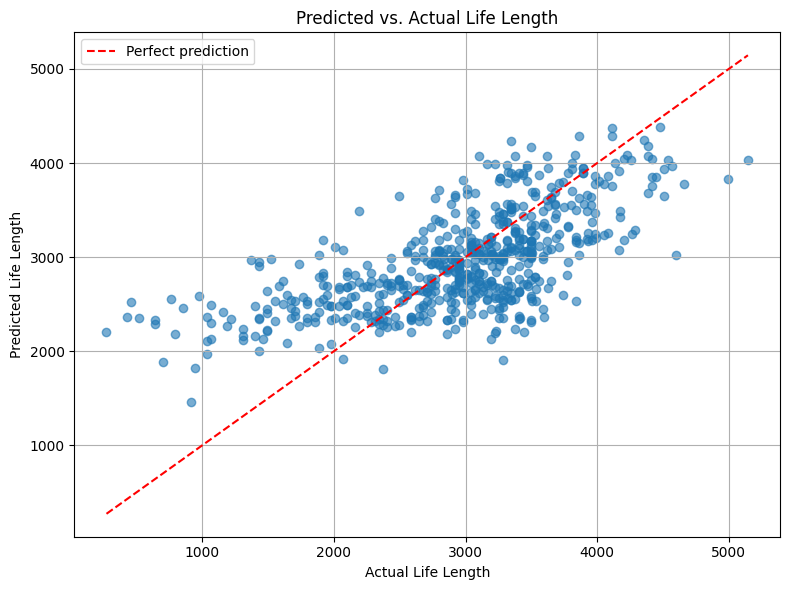

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(life_lengths, preds, alpha=0.6)
plt.plot([min(life_lengths), max(life_lengths)], [min(life_lengths), max(life_lengths)], color='red', linestyle='--', label='Perfect prediction')

plt.xlabel("Actual Life Length")
plt.ylabel("Predicted Life Length")
plt.title("Predicted vs. Actual Life Length")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Checking:  conditions_gastrointestinal.csv
For context, there are 16.0 entries in this dataset per unique dog for the timeframe you have selected
Added feature 5: val MSE = 628630.46280, improvement = inf (total: [5])
Added feature 4: val MSE = 626204.34307, improvement = 2426.11973 (total: [5, 4])
Added feature 9: val MSE = 624051.57642, improvement = 2152.76665 (total: [5, 4, 9])
Added feature 3: val MSE = 622001.69025, improvement = 2049.88617 (total: [5, 4, 9, 3])
Added feature 11: val MSE = 620848.11506, improvement = 1153.57519 (total: [5, 4, 9, 3, 11])
Reached max_features = 5. Stopping.

Selected Features: [5, 4, 9, 3, 11]
Coefficients: [-902.88169673   -5.08296684  825.60208208  340.62973769 -262.98191792]
Best Intercept: 3557.397917921978
Best Validation MSE: 620848.1151
Best R-squared: 0.0102


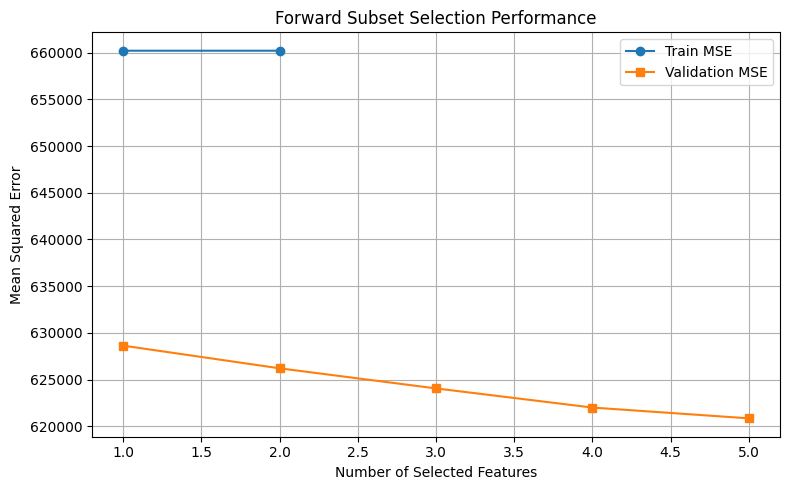

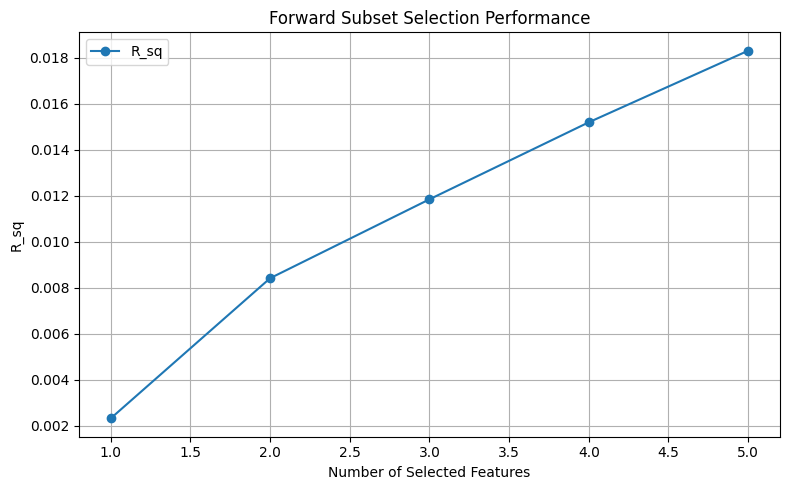

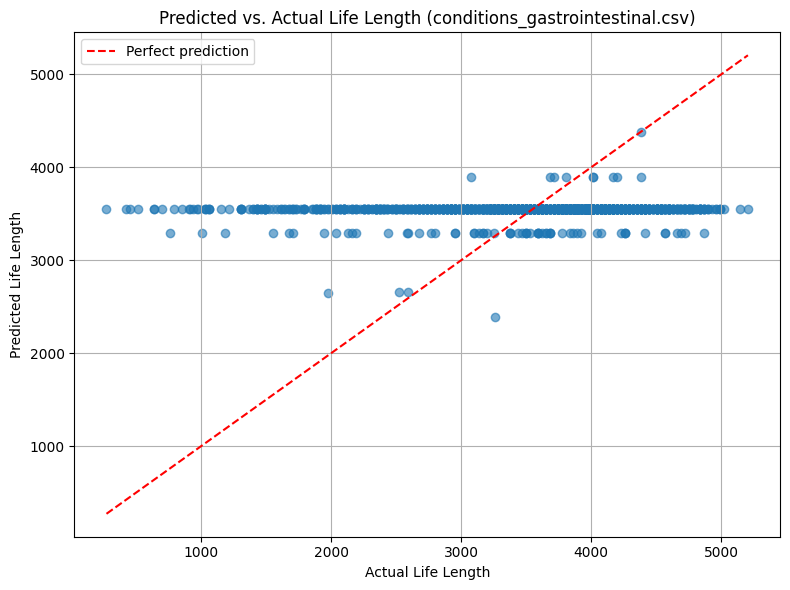

0 	Category:  diarrhea__C 		Coeff:  3544.853144881842
1 	Category:  chronic_colitis__C 		Coeff:  -45.85642213617021
2 	Category:  gastrointestinal_foreign_body__C 		Coeff:  -1.5705436372357218
3 	Category:  bloat_without_torsion__C 		Coeff:  825.6020820780137
4 	Category:  pancreatitis__C 		Coeff:  28.190047257261472
Checking:  dog_profile.csv
For context, there are 1.0 entries in this dataset per unique dog for the timeframe you have selected
year in study is not an included variable in this dataset, this dataset is not valid to use for this function

Selected Features: []
Coefficients: []
Best Intercept: 3545.4727773949
Best Validation MSE: inf
Best R-squared: 0.0000


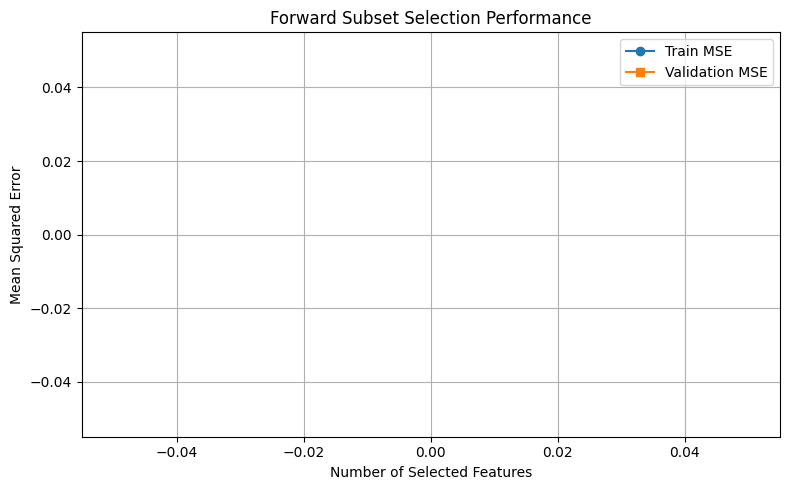

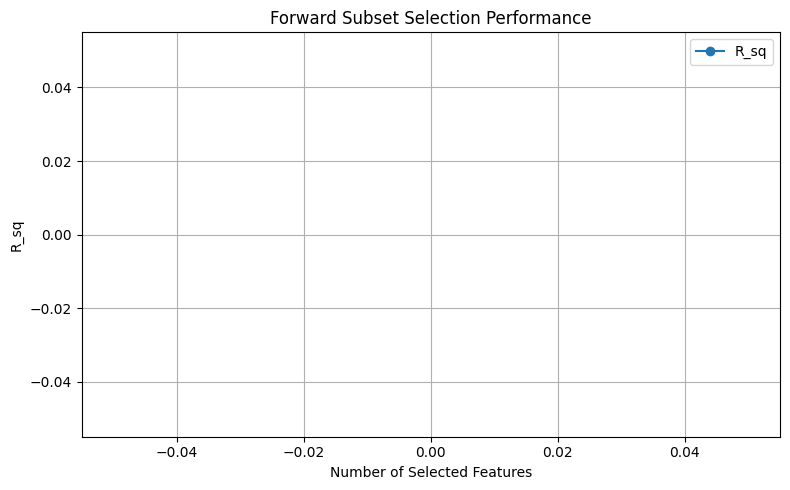

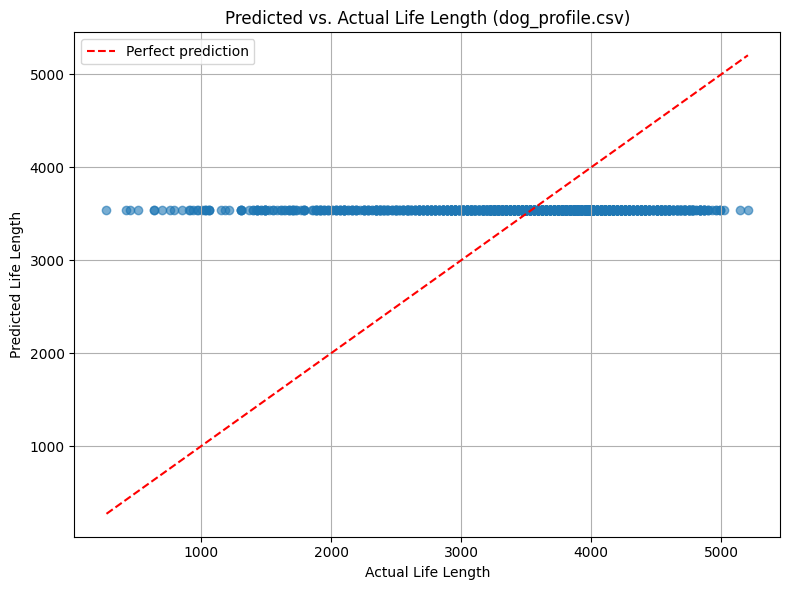

Checking:  environment_conditions.csv
For context, there are 12.709592641261498 entries in this dataset per unique dog for the timeframe you have selected
Added feature 10: val MSE = 565652.27576, improvement = inf (total: [10])
Added feature 6: val MSE = 561391.52521, improvement = 4260.75054 (total: [10, 6])
Added feature 3: val MSE = 560517.46192, improvement = 874.06329 (total: [10, 6, 3])
Added feature 4: val MSE = 559698.98672, improvement = 818.47521 (total: [10, 6, 3, 4])
Added feature 7: val MSE = 559161.06343, improvement = 537.92329 (total: [10, 6, 3, 4, 7])
Reached max_features = 5. Stopping.

Selected Features: [10, 6, 3, 4, 7]
Coefficients: [4.38154685e+02 7.92967785e+00 8.38540115e+01 4.00566458e+01
 1.14829764e-05]
Best Intercept: 3380.605828089768
Best Validation MSE: 559161.0634
Best R-squared: 0.0654


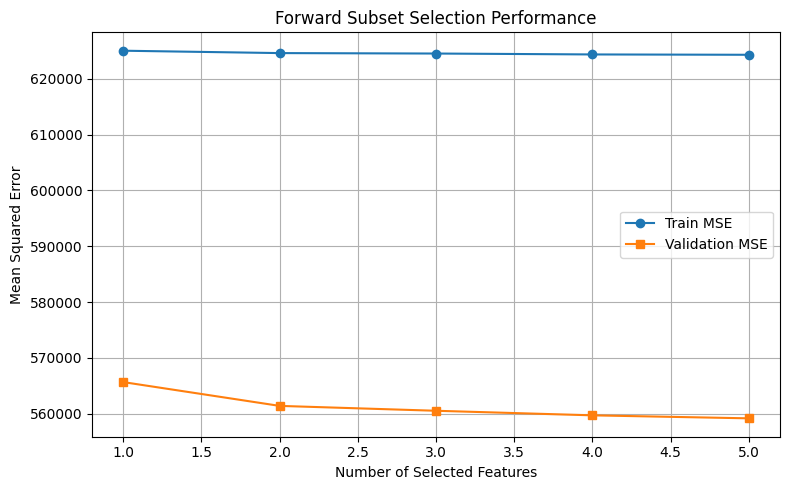

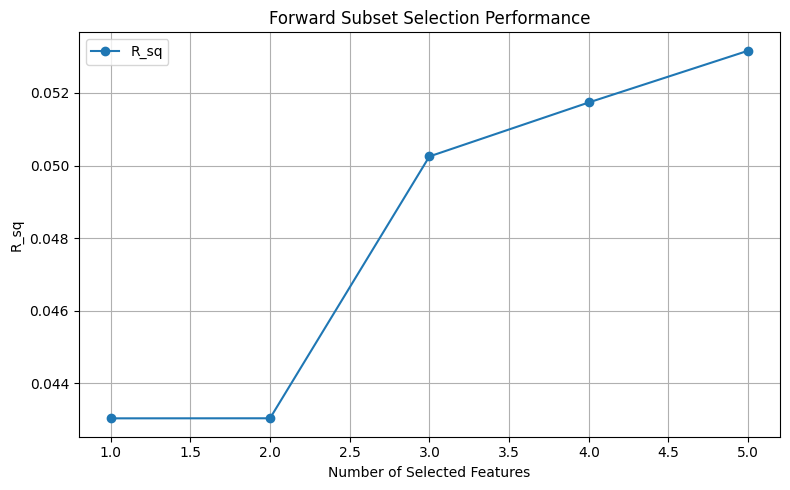

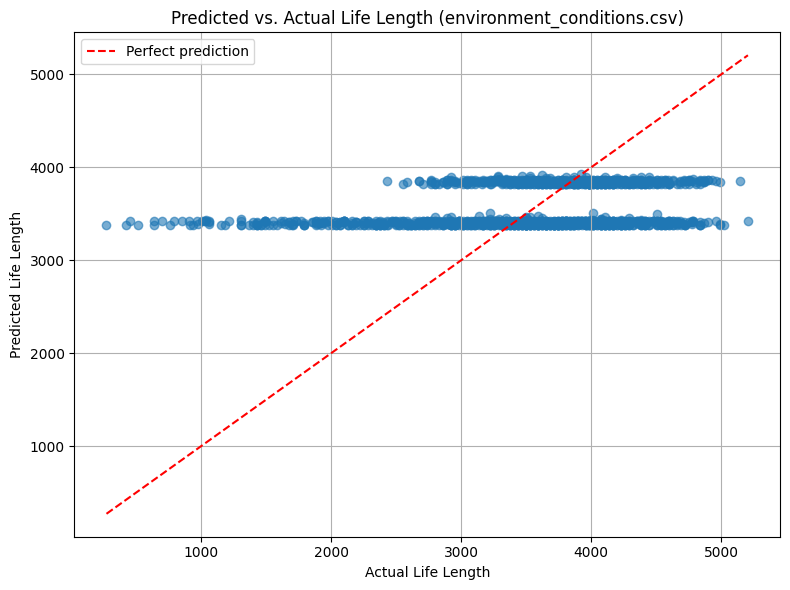

0 	Category:  any_treated_insects__C 		Coeff:  3548.0271325721533
1 	Category:  smoke_exposure__Q 		Coeff:  205.91640650639883
2 	Category:  use_hepa_filter__Q 		Coeff:  1.1988579456379793
3 	Category:  use_moth_balls__Q 		Coeff:  9.475009712926628
4 	Category:  poison_clinic_visit__Q 		Coeff:  16.501654664748887
Checking:  environment_spend_time_location.csv
day_outdoor_garage
day_outdoor_kennel
day_outdoor_fenced
day_outdoor_chain_or_lead
day_outdoor_other_percentage
day_outdoor_total_percentage
For context, there are 5.483902759526938 entries in this dataset per unique dog for the timeframe you have selected
Added feature 3: val MSE = 527928.05780, improvement = inf (total: [3])
Added feature 12: val MSE = 523887.79758, improvement = 4040.26023 (total: [3, 12])
Added feature 0: val MSE = 520705.35840, improvement = 3182.43917 (total: [3, 12, 0])
Added feature 6: val MSE = 518371.59049, improvement = 2333.76791 (total: [3, 12, 0, 6])
Added feature 13: val MSE = 516321.48031, improvem

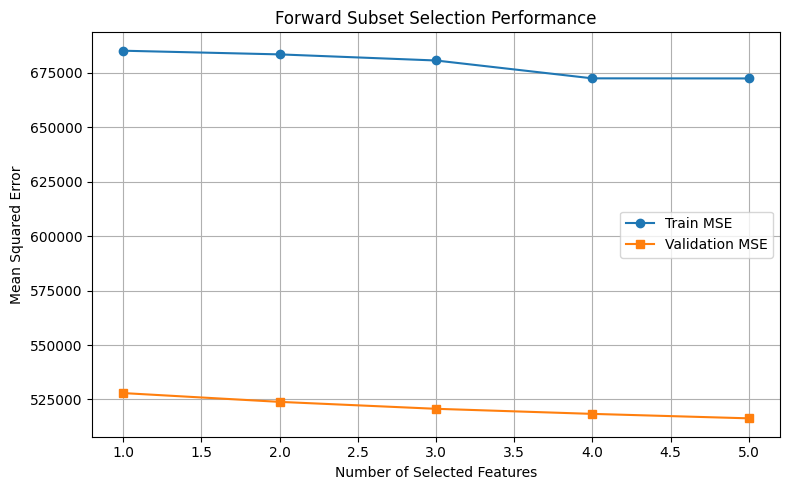

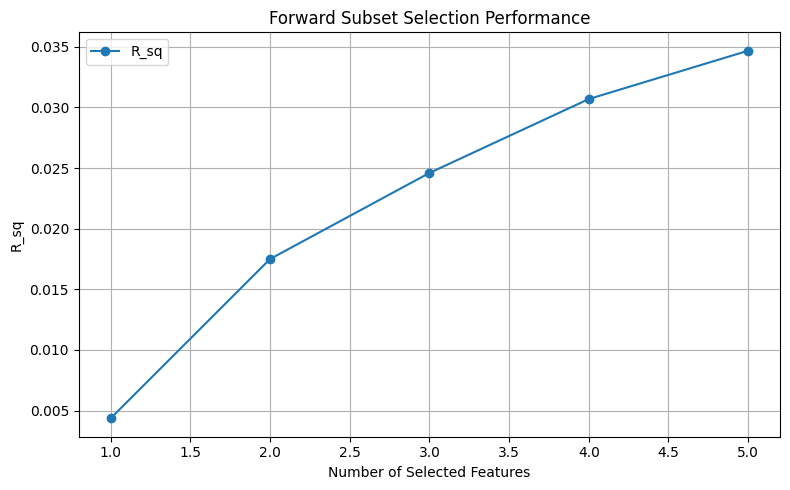

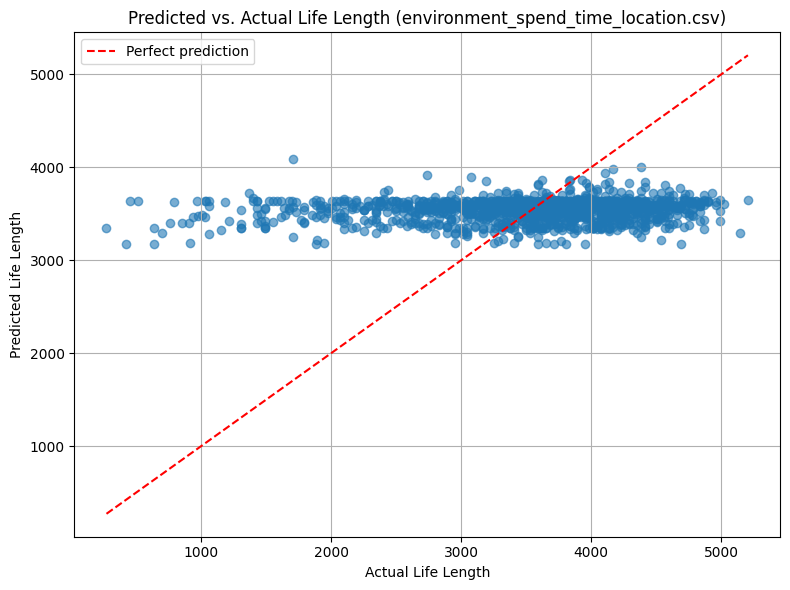

0 	Category:  indoor_hardwood_flooring__Q 		Coeff:  3544.666090153166
1 	Category:  furniture_type_upholstered__Q 		Coeff:  16.111529078273346
2 	Category:  year_in_study__Q_x 		Coeff:  54.14194390163717
3 	Category:  indoor_linoleum_flooring__Q 		Coeff:  -48.08581802784873
4 	Category:  furniture_type_other__Q 		Coeff:  -85.96259627780712
Checking:  exam_physical.csv
For context, there are 6.889618922470434 entries in this dataset per unique dog for the timeframe you have selected
Added feature 5: val MSE = 622190.41807, improvement = inf (total: [5])
Added feature 1: val MSE = 602599.88348, improvement = 19590.53459 (total: [5, 1])
Added feature 2: val MSE = 600861.41552, improvement = 1738.46796 (total: [5, 1, 2])
Added feature 0: val MSE = 599761.37088, improvement = 1100.04464 (total: [5, 1, 2, 0])
Added feature 4: val MSE = 598874.82207, improvement = 886.54880 (total: [5, 1, 2, 0, 4])
Reached max_features = 5. Stopping.

Selected Features: [5, 1, 2, 0, 4]
Coefficients: [-5.75005

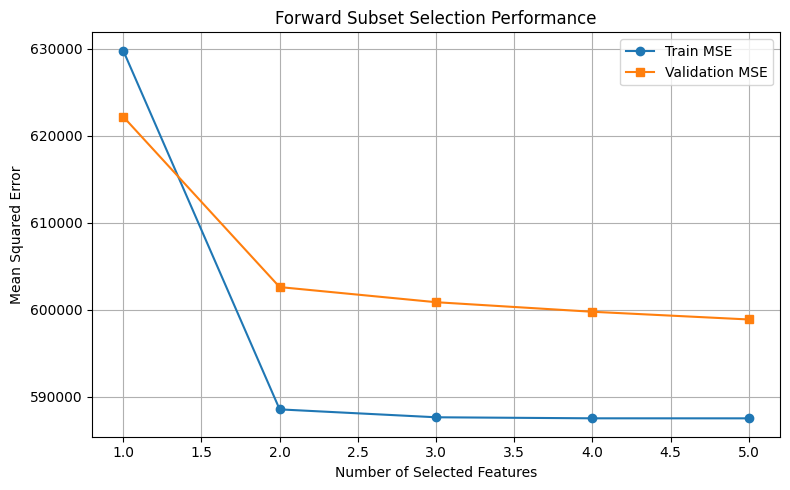

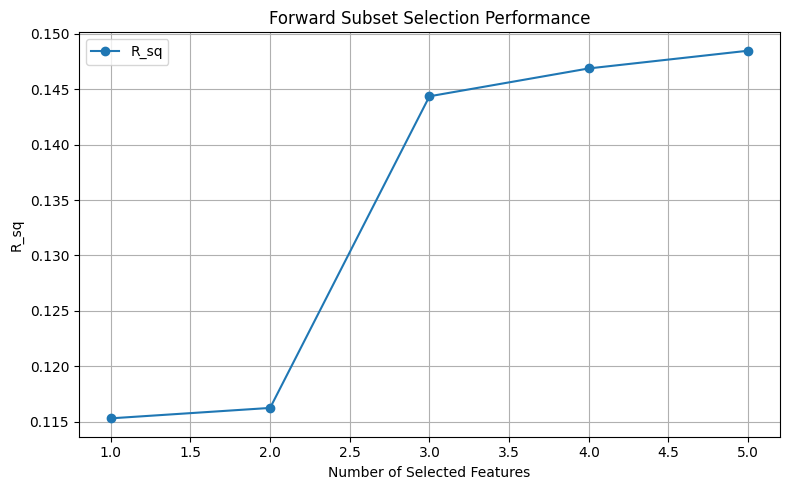

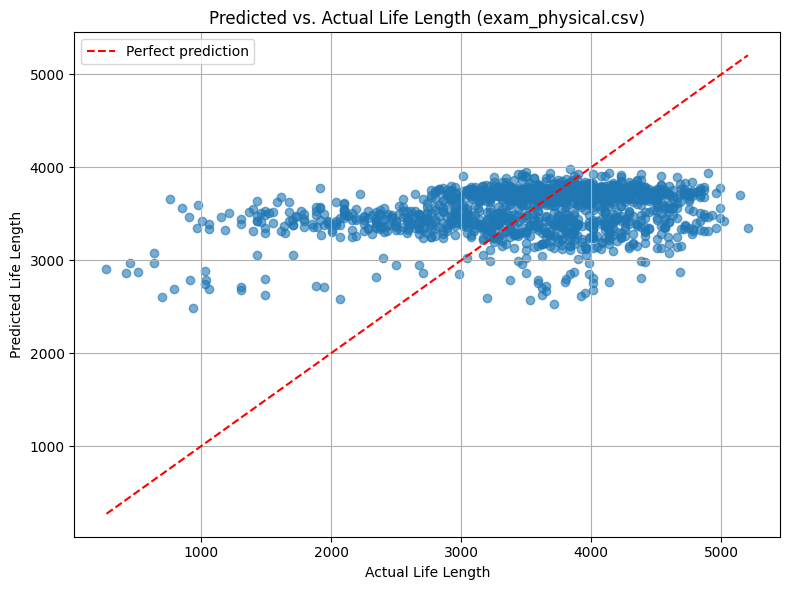

0 	Category:  capillary_refill_not_evaluated__C 		Coeff:  3542.4727031013335
1 	Category:  index 		Coeff:  -126.33782718077669
2 	Category:  weight__C 		Coeff:  -192.29859846498834
3 	Category:  year_in_study__Q_x 		Coeff:  31.7508057515756
4 	Category:  pulse__C 		Coeff:  -2.4140458870325183
Checking:  poison_exposure.csv
For context, there are 1.3103448275862069 entries in this dataset per unique dog for the timeframe you have selected
Added feature 0: val MSE = 579774.37917, improvement = inf (total: [0])

Selected Features: [0]
Coefficients: [543.86969253]
Best Intercept: 3649.4202049780392
Best Validation MSE: 579774.3792
Best R-squared: 0.0057


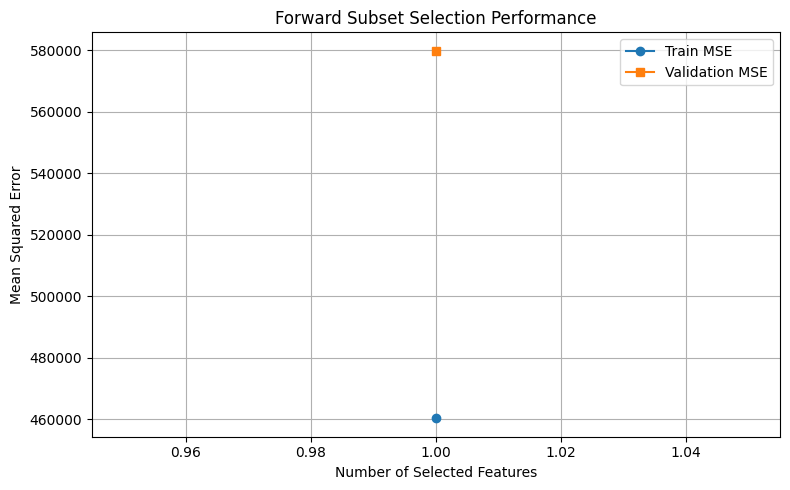

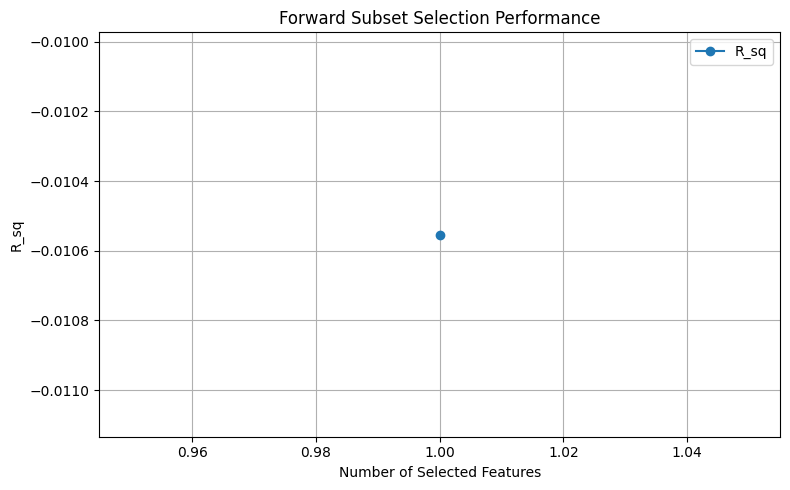

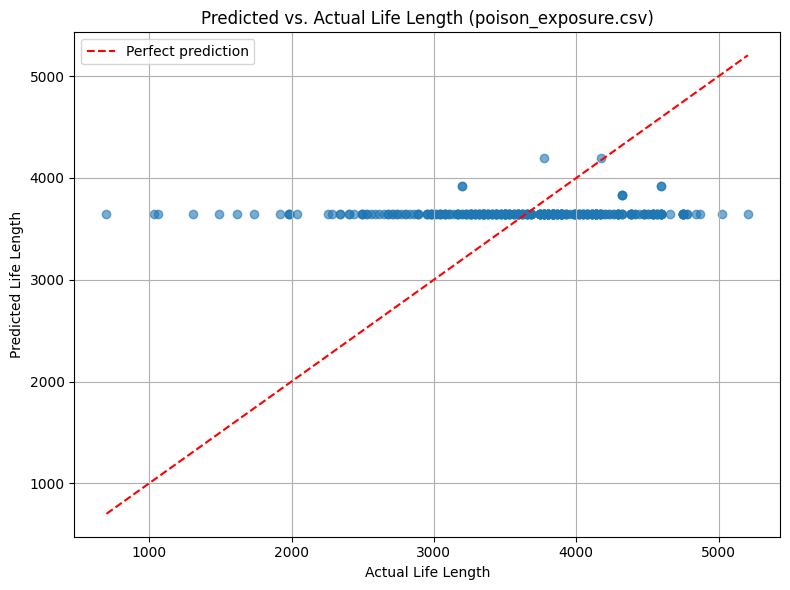

0 	Category:  year_in_study__Q 		Coeff:  3659.1669736614253
Checking:  study_endpoints.csv
For context, there are 1.1457725947521866 entries in this dataset per unique dog for the timeframe you have selected
Added feature 2: val MSE = 390655.61491, improvement = inf (total: [2])
Added feature 3: val MSE = 244850.72439, improvement = 145804.89052 (total: [2, 3])
Added feature 0: val MSE = 242306.38695, improvement = 2544.33744 (total: [2, 3, 0])
Added feature 4: val MSE = 241638.85177, improvement = 667.53517 (total: [2, 3, 0, 4])
Added feature 5: val MSE = 241522.04303, improvement = 116.80874 (total: [2, 3, 0, 4, 5])
Reached max_features = 5. Stopping.

Selected Features: [2, 3, 0, 4, 5]
Coefficients: [ 288.2851938  -773.66045989  -72.51386164  171.34364538  -27.5568146 ]
Best Intercept: 2078.8911341706753
Best Validation MSE: 241522.0430
Best R-squared: 0.6801


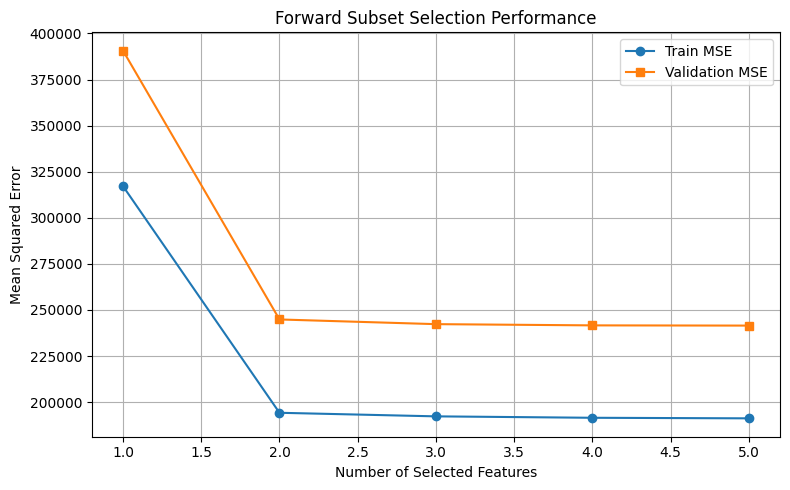

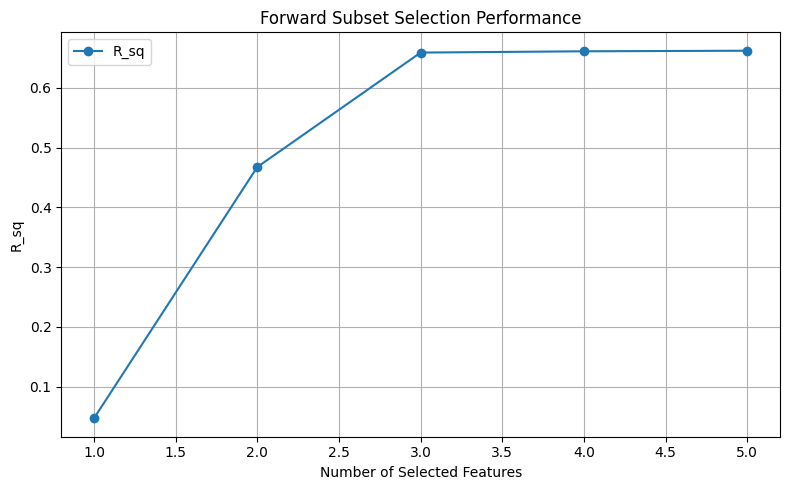

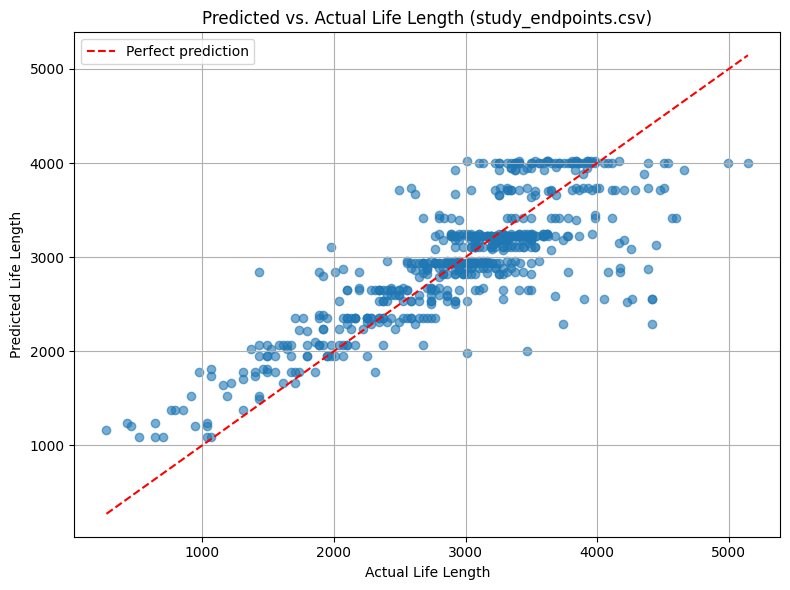

0 	Category:  index 		Coeff:  2954.973739786708
1 	Category:  year_in_study__Q_y 		Coeff:  513.4483390470439
2 	Category:  year_in_study__Q_x 		Coeff:  -346.12146693254357
3 	Category:  is_cause_of_death__C 		Coeff:  -54.002882431814804
4 	Category:  is_recurrence__C 		Coeff:  7.837058700694924


In [14]:
negative_factors = []
positive_factors = []

for datapath in datapaths:
    print("Checking: ", datapath)
    full_path = "data/" + datapath
    temp = data_loader(file_path=full_path)
    temp.download_csv()
    temp.identify_type()
    temp.clean_junk()
    temp.select_year("all")
    temp.age_death_variable()
    df = temp.file

    df_filtered = df[df['lifespan_days__Q'].notna()] # Only use entries with usable life-lengths
    df_filtered = df_filtered.loc[:, df_filtered.nunique() > 1] # Remove any useless columns which snuck in
    life_lengths = df_filtered['lifespan_days__Q'].dt.days.to_numpy()
    life_lengths = life_lengths.astype(float)

    df_filtered = df_filtered.select_dtypes(exclude=['object', 'string', 'datetime'])
    data_array = df_filtered.values[:,1:-1]
    data_array = data_array.astype(float)

    selected_features, theta, preds, mse, r2 = forward_subset_selection(
    data_array, life_lengths, val_ratio=0.2, epsilon=1e-4, max_features=5)

    plt.figure(figsize=(8, 6))
    plt.scatter(life_lengths, preds, alpha=0.6)
    plt.plot([min(life_lengths), max(life_lengths)], [min(life_lengths), max(life_lengths)], color='red', linestyle='--', label='Perfect prediction')

    plt.xlabel("Actual Life Length")
    plt.ylabel("Predicted Life Length")
    title = "Predicted vs. Actual Life Length (" + datapath + ")"
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    column_names = df_filtered.columns[selected_features].tolist()

    for index, name in enumerate(column_names):
        print(index, "\tCategory: ", name, "\t\tCoeff: ", theta[index])
        if theta[index] >= 0:
            positive_factors.append(name)
        else:
            negative_factors.append(name)

unique_positive_factors = list(set(positive_factors))
unique_negative_factors = list(set(negative_factors))

In [15]:
print("Positive Factors: ")
print(unique_positive_factors)
print("Negative Factors: ")
print(unique_negative_factors)

# Promising negative factors:
# Pulse -- high pulse may be correlated with shorter lifetime
# Weight -- high weight may be correlated with shorter lifetime
# Chronic Colitis (inflamation) -- may be correlated with shorter lifetime
# Gastrointestinal Foreign Body -- swallowing foreign bodies may

Positive Factors: 
['use_moth_balls__Q', 'year_in_study__Q', 'bloat_without_torsion__C', 'any_treated_insects__C', 'pancreatitis__C', 'furniture_type_upholstered__Q', 'index', 'indoor_hardwood_flooring__Q', 'is_recurrence__C', 'smoke_exposure__Q', 'capillary_refill_not_evaluated__C', 'use_hepa_filter__Q', 'poison_clinic_visit__Q', 'year_in_study__Q_x', 'year_in_study__Q_y', 'diarrhea__C']
Negative Factors: 
['furniture_type_other__Q', 'pulse__C', 'is_cause_of_death__C', 'weight__C', 'chronic_colitis__C', 'indoor_linoleum_flooring__Q', 'year_in_study__Q_x', 'index', 'gastrointestinal_foreign_body__C']


In [8]:
# Lasso selection
lasso_features, coefs, intercept, preds, alpha, val_mse, r_sq = lasso_feature_selection(
    data_array, life_lengths, val_ratio=0.2, alpha_min=1e-10, alpha_max=1e3, n_alphas=50
)

Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MSE: nan, Val MSE: nan, R²: nan, Active features: 2
Alpha: 0.000000, Train MS

In [7]:
print(lasso_features)

None
